In [1]:
import os
os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.chdir('/home/wcy/code/pyFile/RIFF_package/v1107/')
import warnings
warnings.filterwarnings("ignore")
import argparse
import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

import pandas as pd
from sklearn.metrics import adjusted_rand_score

import Riff

In [2]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=0)
parser.add_argument("--device", type=int, default=3)
parser.add_argument("--warmup_steps", type=int, default=-1)
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--weight_decay", type=float, default=2e-4, help="weight decay")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--lr_f", type=float, default=0.01, help="learning rate for evaluation")
parser.add_argument("--weight_decay_f", type=float, default=1e-4, help="weight decay for evaluation")
parser.add_argument("--linear_prob", action="store_true", default=True)
parser.add_argument("--load_model", action="store_true")
parser.add_argument("--save_model", action="store_true")
parser.add_argument("--use_cfg", action="store_true")
parser.add_argument("--logging", action="store_true")
parser.add_argument("--scheduler", action="store_true", default=True)

# for graph classification
parser.add_argument("--pooling", type=str, default="mean")
parser.add_argument("--deg4feat", action="store_true", default=False, help="use node degree as input feature")
parser.add_argument("--batch_size", type=int, default=32)

# adjustable parameters
parser.add_argument("--encoder", type=str, default="gin")
parser.add_argument("--decoder", type=str, default="gin")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--max_epoch", type=int, default=200, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--alpha_l", type=float, default=4, help="`pow`inddex for `sce` loss")
parser.add_argument("--beta_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.8)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.5)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm")

# RIF parameter
parser.add_argument("--folder_name", type=str, default="/home/wcy/code/datasets/Visium/")  
parser.add_argument("--sample_name", type=str, default="V1_Mouse_Brain_Sagittal_Posterior")
parser.add_argument("--seq_tech", type=str, default="Visuim")
parser.add_argument("--cluster_label", type=str, default= "")
parser.add_argument("--num_classes", type=int, default=26, help = "The number of clusters")
parser.add_argument("--output_folder", type=str, default="/home/wcy/code/pyFile/RIFF_package/v1107/output")

parser.add_argument("--num_neighbors", type=int, default=7)
parser.add_argument("--confidence_threshold", type=float, default=3e-3)
parser.add_argument("--pre_aggregation", type=int, default=[1, 1]) 
parser.add_argument("--min_pseudo_label", type=int, default=3000)
parser.add_argument("--num_features", type=int, default=3000)
parser.add_argument("--top_num", type=int, default=40)
parser.add_argument("--radius", type=int, default=0)

args = parser.parse_args(args=['--sample_name', 'V1_Mouse_Brain_Sagittal_Posterior']) 
args

Namespace(activation='elu', alpha_l=4, attn_drop=0.1, batch_size=32, beta_l=2, cluster_label='', confidence_threshold=0.003, decoder='gin', deg4feat=False, device=3, drop_edge_rate=0.0, encoder='gin', folder_name='/home/wcy/code/datasets/Visium/', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='weighted_mse', lr=0.001, lr_f=0.01, mask_gene_rate=0.8, max_epoch=200, min_pseudo_label=3000, negative_slope=0.2, norm='batchnorm', num_classes=26, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=7, num_out_heads=1, optimizer='adam', output_folder='/home/wcy/code/pyFile/RIFF_package/v1107/output', pooling='mean', pre_aggregation=[1, 1], radius=0, remask_rate=0.5, replace_rate=0.05, residual=False, sample_name='V1_Mouse_Brain_Sagittal_Posterior', save_model=False, scheduler=True, seeds=0, seq_tech='Visuim', top_num=40, use_cfg=False, warm_up=50, warmup_steps=-1, weight_decay=0.0002, weight_decay_f=0.0001)

# 1. Preprocessing

In [3]:
data_path = os.path.join(args.folder_name, args.sample_name)
adata = Riff.Read_Visium_with_label(data_path)                                    # Read standard 10x Visium data

In [4]:
if(args.cluster_label != ""):
    args.num_classes = adata.obs[args.cluster_label].nunique()
    adata.obs[args.cluster_label] = adata.obs[args.cluster_label].astype('category')

adata = Riff.Preprocess_adata(args, adata)
adata, graph = Riff.Build_graph(args, adata, spatial_key='image_coor')
adata = Riff.Generate_pseudo_label(args, adata, graph)
adata

=================== Contructing graph =====================
================== Generating pseudo-label ================
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 3355 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'pseudo_label', 'uncertainty', 'pseudo_label_scaled', 'uncertainty_scaled'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'image_coor', 'emb_pca', 'mclust_prob', 'mclust_prob_scaled'

# 2. Training and spatial domain identification

In [5]:
adata, _ = Riff.Train(args, adata, graph) 

==================== Building model ====================
==================== Start training ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.29it/s]


Trained model saved to /home/wcy/code/pyFile/RIFF_package/v1107/output/model/V1_Mouse_Brain_Sagittal_Posterior.pth


In [6]:
adata, new_key = Riff.Ensemble_clustering(adata, args.radius, args.num_classes, args.top_num)

=================== Combining Result ===================
Nothing changed!


... storing 'feature_types' as categorical
... storing 'genome' as categorical


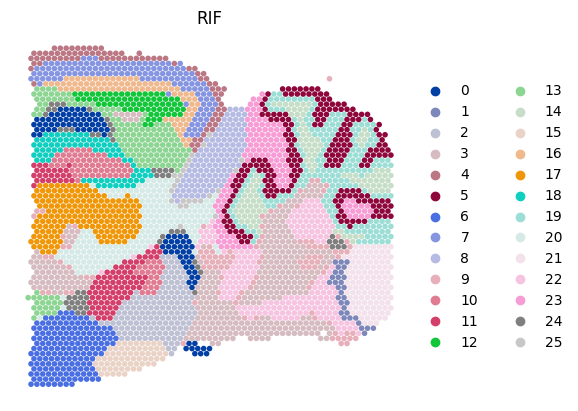

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt

adata.obs['combined'] = adata.obs['combined'].astype(int).astype('category')
sc.pl.embedding(adata, basis='image_coor', color=['combined'], title=['RIF'], s=65, frameon=False, show=False)
plt.gca().set_aspect(1)
plt.gca().invert_yaxis()
plt.show()